In [39]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

from collections import defaultdict
# from dynchro.tl import dtw, traceback, warp_pseudotime

import dynchro

# 1. Preprocess data

In [2]:
d1 = ad.read_h5ad("data/dataseta2.h5ad")
d2 = ad.read_h5ad("data/datasetb2.h5ad")

d1.uns["iroot"] = np.flatnonzero(d1.obs["sim_time"] == 0.0)[5]
d2.uns["iroot"] = np.flatnonzero(d2.obs["sim_time"] == 0.0)[5]

d2 = d2[d2.obs["milestones"] != "sEndC", :]

d1, d2

(AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
     obsm: 'dimred'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts',
 View of AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna',

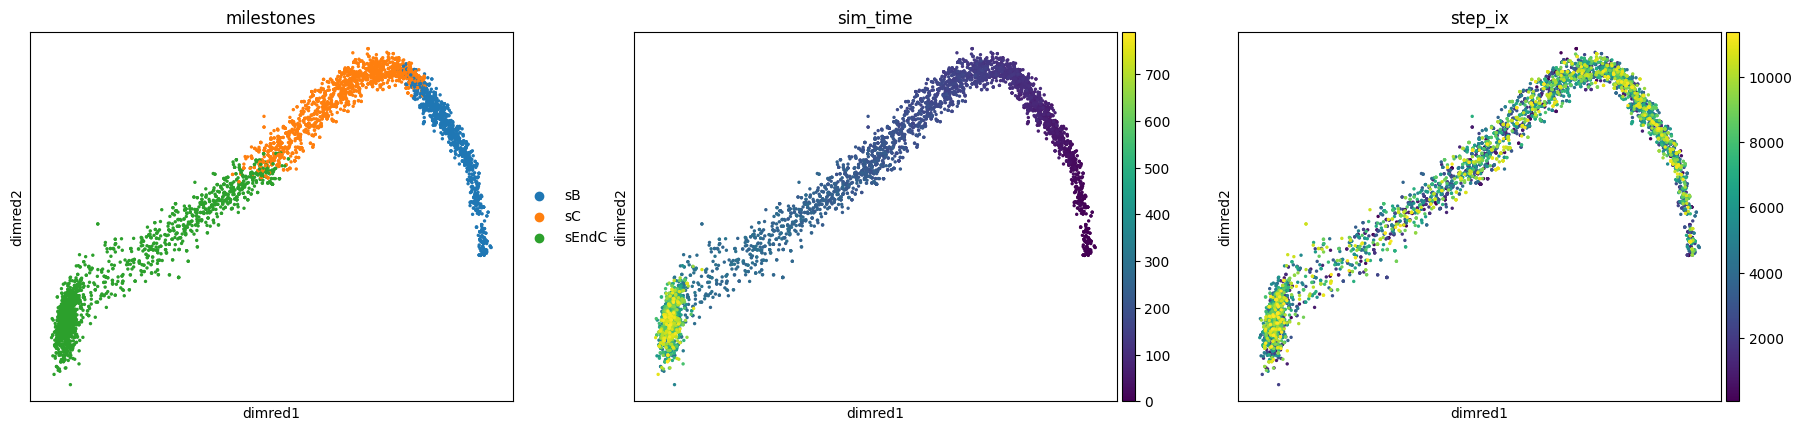

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


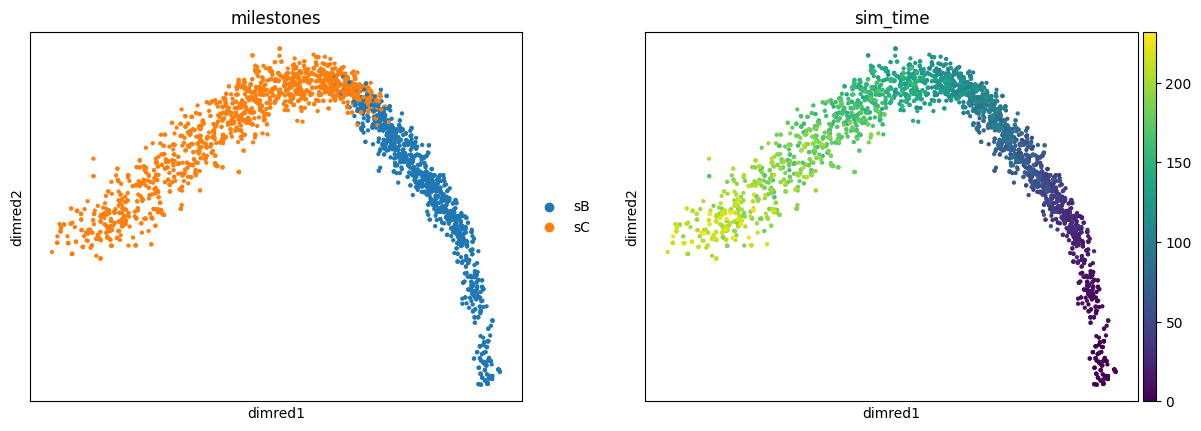

In [3]:
sc.pl.embedding(d1, basis = "dimred", color = ["milestones", "sim_time", "step_ix"])
sc.pl.embedding(d2, basis = "dimred", color = ["milestones", "sim_time"])

In [4]:
def preprocess(dataset):
    sc.pp.normalize_total(dataset, target_sum=1e4)
    sc.pp.log1p(dataset)
    sc.pp.pca(dataset)
    sc.pp.neighbors(dataset, n_neighbors=15)
    sc.tl.umap(dataset)
    sc.tl.leiden(dataset)
    return dataset

In [5]:
d1 = preprocess(d1)
d2 = preprocess(d2)

/tmp/ipykernel_7272/683822307.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(dataset)


In [6]:
sc.tl.diffmap(d1)
sc.tl.diffmap(d2)

sc.tl.dpt(d1, n_dcs=10)
sc.tl.dpt(d2, n_dcs=10)
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

# argsort on pseudotime
d1 = d1[np.argsort(d1.obs["pseudotime"]), :]
d2 = d2[np.argsort(d2.obs["pseudotime"]), :]

d1, d2

(View of AnnData object with n_obs × n_vars = 5000 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
     uns: 'iroot', 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions', 'milestones_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'diffmap_evals'
     obsm: 'dimred', 'X_pca', 'X_umap', 'X_diffmap'
     varm: 'PCs'
     layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 3132 × 522
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'pseudotime'
     var:

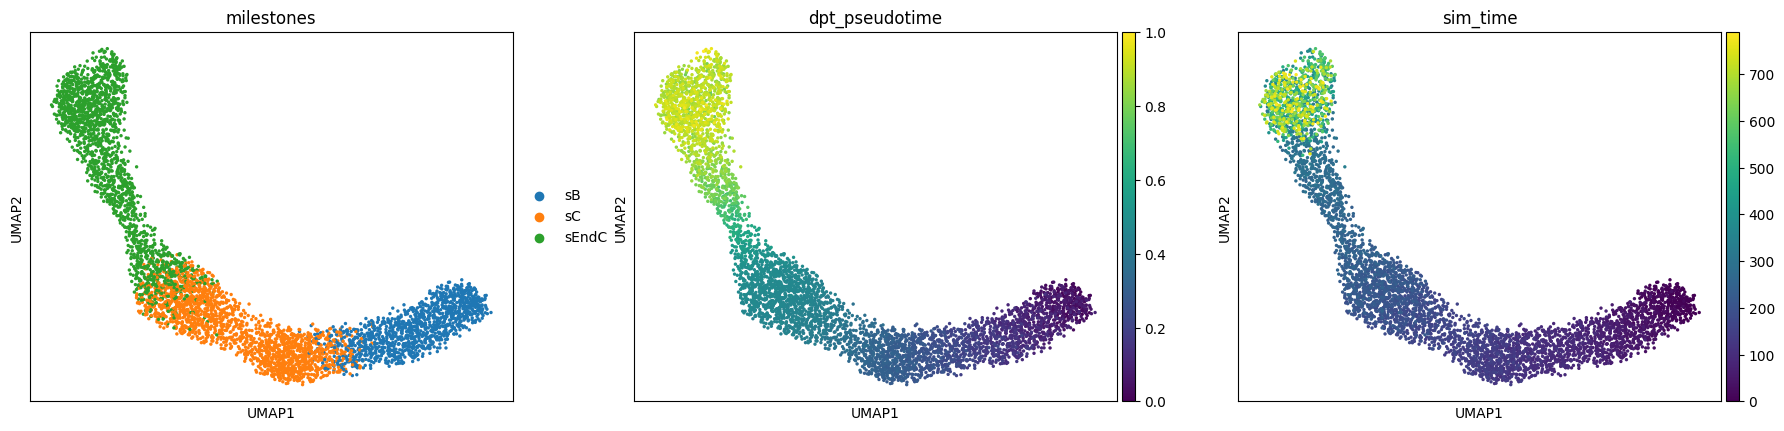

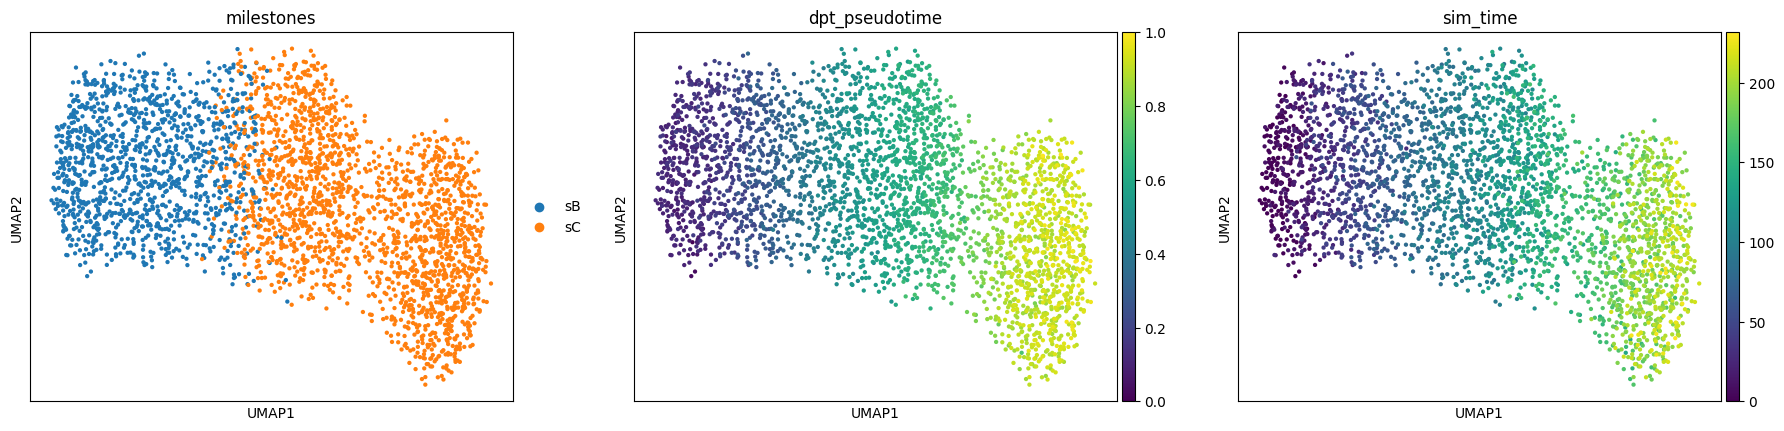

In [7]:
sc.pl.umap(d1, color=["milestones", "dpt_pseudotime", "sim_time"])
sc.pl.umap(d2, color=["milestones", "dpt_pseudotime", "sim_time"])

# 2. Generate pseudocells

In [8]:
# Generate pseudocells
def calculate_pseudocells(adata, amount: int):
    trunc_anndata = adata
    pseudocell_pseudotimes = interpolate_pseudocells(trunc_anndata, amount)
    trunc_anndata, pseudocells = smooth_pseudocells(trunc_anndata, pseudocell_pseudotimes, amount)

    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, pseudocell_pseudotimes)}

    # Save information into anndata
    adata.varm[f"pseudocells_{amount}"] = pseudocells.T
    adata.uns[f"pseudocells_{amount}_pseudotime"] = pd.Series(pseudocell_pseudotimes)
    if "pseudocells" not in adata.uns:
        adata.uns["pseudocells"] = []
    adata.uns["pseudocells"] += [f"pseudocells_{amount}"]
    return adata

def calc_pc(adata, amount, obsm_key=None):
    interpolated = interpolate_uniform(adata, amount)
    adata, pseudocells, transition_matrix = smooth_pseudocells(adata, interpolated, amount, obsm_key)
    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, interpolated)}

    return adata, pseudocells, pseudocell_pseudotimes, transition_matrix


def interpolate_pseudocells(adata, amount: int):
    # interpolate pseudotime based on the distribution of real cells in the pseudotime
    return np.percentile(sorted(adata.obs.pseudotime.values), np.linspace(0.0, 100, amount))

def interpolate_uniform(adata, amount: int):
    # interpolate pseudotime uniformly
    min_pseudotime = adata.obs.pseudotime.min()
    max_pseudotime = adata.obs.pseudotime.max()
    return np.linspace(min_pseudotime, max_pseudotime, amount)


def smooth_pseudocells(adata, pseudocell_pseudotimes, amount: int, obsm_key=None) -> np.ndarray:
    distances = calculate_pseudotime_distance(pseudocell_pseudotimes, sorted(adata.obs.pseudotime.values))
    adata.uns[f"transition_matrix_{amount}"] = np.array(
        [get_gaussian_transition_matrix(distances[i,], adata.X) for i in range(distances.shape[0])]
    )
    features = adata.X
    if obsm_key is not None:
        features = adata.obsm[obsm_key]
    return adata, np.array([apply_gaussian_kernel(distances[i,], features) for i in range(distances.shape[0])]), adata.uns[f"transition_matrix_{amount}"]

def calculate_pseudotime_distance(pseudocell_pseudotimes, trajectory_pseudotime: np.ndarray) -> np.ndarray:
    distances = []
    for cell in pseudocell_pseudotimes:
        distance = trajectory_pseudotime - cell
        distances.append(distance)
    return np.array(distances)

def apply_gaussian_kernel(x, counts):
    d = get_gaussian_transition_matrix(x, counts)
    
    # d = np.exp(-1 * (x**2) / (2**2))

    # FOR VISUALISATION PURPOSES
    # import matplotlib.pyplot as plt

    # plt.plot(x, color = "red")
    # plt.plot(d, color = "blue")
    # plt.figure()
    # plt.show()

    # d = d / sum(d)
    # plt.plot(d, color = "green")

    # plt.show()

    # @ = matrix multiplication (is transposition necessary or could the arguments be switched?)
    return counts.T @ d


def get_gaussian_transition_matrix(x, counts):
    d = np.exp(-1 * (x**2) / (0.0075**2))
    return d / sum(d)



In [9]:
d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]

d1_, pseudocells1, pseudocell_pseudotimes1, d1_trans = calc_pc(d1, 100)
d2_, pseudocells2, pseudocell_pseudotimes2, d2_trans = calc_pc(d2, 100)

/tmp/ipykernel_7272/480571304.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1.obs["pseudotime"] = d1.obs["dpt_pseudotime"]
/tmp/ipykernel_7272/480571304.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2.obs["pseudotime"] = d2.obs["dpt_pseudotime"]


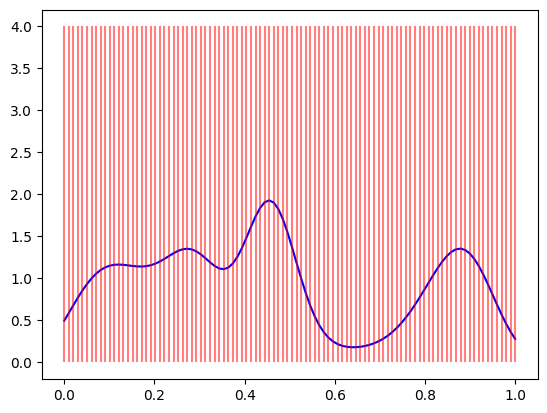

In [10]:
pseudotimes_kde_orig = sp.stats.gaussian_kde(d1.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes1.values(), 0, 4, color = "red", alpha=0.5)

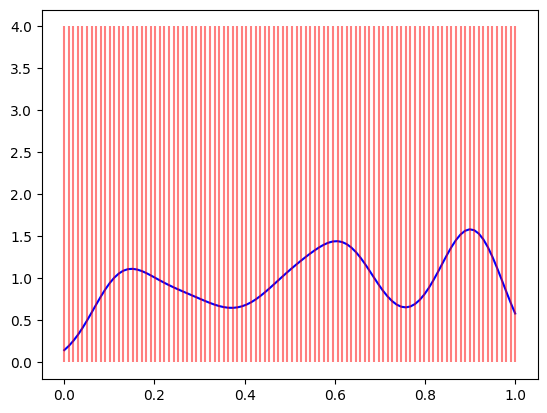

In [11]:
pseudotimes_kde_orig2 = sp.stats.gaussian_kde(d2.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig2(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(pseudocell_pseudotimes2.values(), 0, 4, color = "red", alpha=0.5)

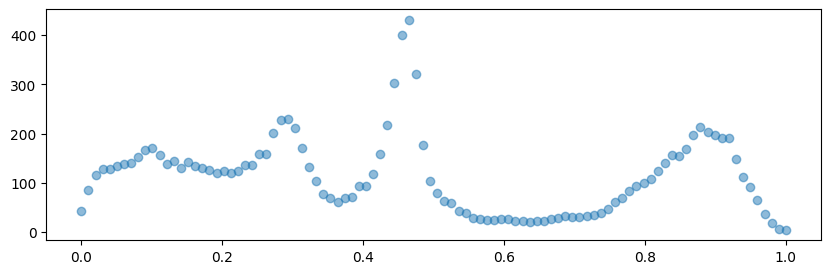

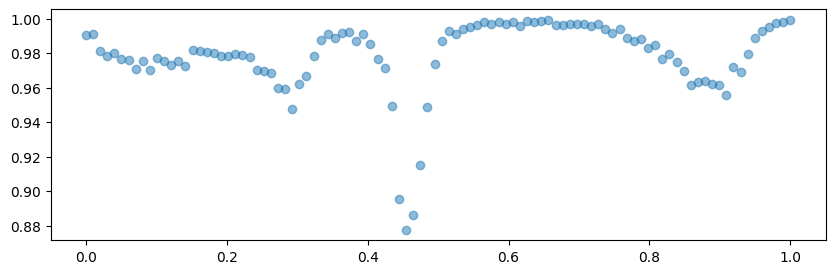

In [12]:
# get all contributions
threshold = 0.001
contributions = []
contributing_cells = []
for i in range(d1_trans.shape[0]):
    contributing_cells_part = d1_trans[i,:] >= threshold
    contributing_cells.append(contributing_cells_part)
    contribution = d1_trans[i,:][d1_trans[i, :] >= threshold]
    contributions.append((sum(contribution), len(contribution)))
    # contributing_cells.extend([i] * len(contribution))

# plot amount covered and number of cells contributing
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values(), [x[1] for x in contributions], alpha=0.5)
plt.show()
plt.figure(figsize=(10, 3))
plt.scatter(pseudocell_pseudotimes1.values(), [x[0] for x in contributions], alpha=0.5)

# 3. Run DTW on pseudocells

In [47]:
d3 = ad.AnnData(X = pseudocells1, var = d1.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes1}))
d4 = ad.AnnData(X = pseudocells2, var = d2.var, obs = pd.DataFrame({"pseudotime": pseudocell_pseudotimes2}))
d3, d4

(AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein',
 AnnData object with n_obs × n_vars = 100 × 522
     obs: 'pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein')

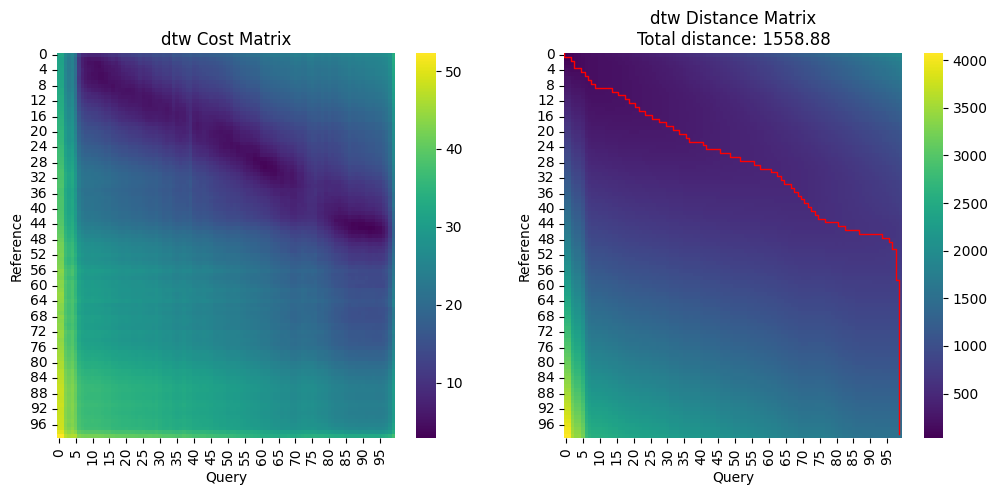

In [52]:
d3, d4 = dynchro.tl.dtw(d3, d4)
d3, d4 = dynchro.tl.traceback(d3, d4)

d4 = dynchro.tl.warp_pseudotime(d3, d4)
d3 = dynchro.tl.warp_pseudotime(d4, d3)

dynchro.pl.plot_dtw_matrices(d3, d4)

# 4. Run DTW on actual cells

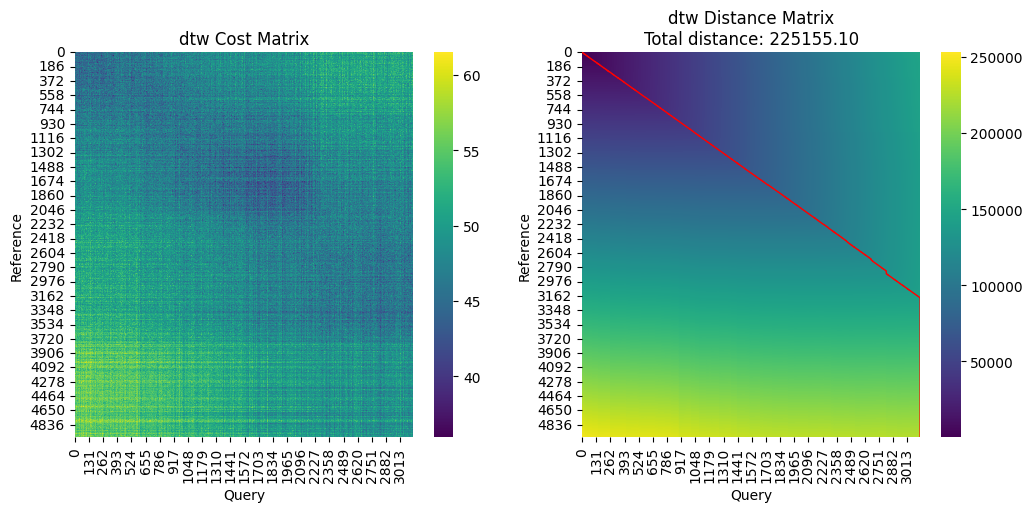

In [53]:
d1, d2 = dynchro.tl.dtw(d1, d2)
d1, d2 = dynchro.tl.traceback(d1, d2)

d2 = dynchro.tl.warp_pseudotime(d1, d2)
d1 = dynchro.tl.warp_pseudotime(d2, d1)

dynchro.pl.plot_dtw_matrices(d1, d2)


# 5. Compare warpings

In [63]:
def map_back(transition_matrix, pseudocell_dataset):
    tresh = 0.001
    mapped_warped_pseudotimes = []
    for i in range(transition_matrix.shape[1]):
        res = transition_matrix[:, i] / sum(transition_matrix[:, i])

        warped_pseudotimes = pseudocell_dataset.obs[res > tresh].dtw_warped_pseudotime.values
        contribution_amounts = res[res > tresh]

        result = np.average(warped_pseudotimes, weights=contribution_amounts)
        mapped_warped_pseudotimes.append(result)

    return mapped_warped_pseudotimes

In [64]:
d3

AnnData object with n_obs × n_vars = 100 × 522
    obs: 'pseudotime', 'dtw_path', 'dtw_cells_path', 'dtw_warped_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'dtw_distance'
    obsm: 'dtw_cost', 'dtw_D'

In [69]:
mapped_warped_1 = map_back(transition_matrix=d2_trans, pseudocell_dataset=d4)
mapped_warped_2 = map_back(transition_matrix=d1_trans, pseudocell_dataset=d3)

d2.obs["mapped_warped_pseudotime"] = mapped_warped_1
d1.obs["mapped_warped_pseudotime"] = mapped_warped_2

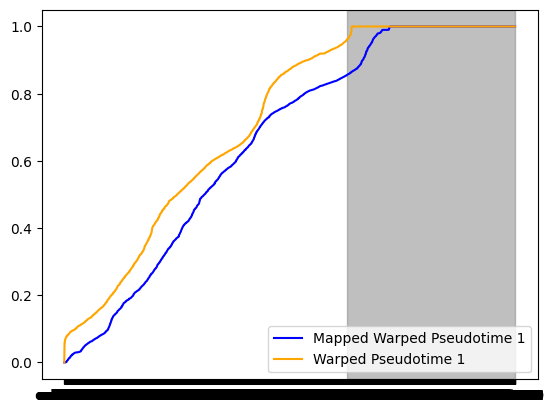

In [70]:
plt.plot(d1.obs["mapped_warped_pseudotime"], label="Mapped Warped Pseudotime 1", color='blue')
plt.plot(d1.obs["dtw_warped_pseudotime"], label="Warped Pseudotime 1", color='orange')

# plot square on x axis from end to end - 1868
plt.axvspan(5000-1868, 5000, color='gray', alpha=0.5)

plt.legend()

# 6. Figure

In [71]:
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)

import numpy as np

def get_colors(colors, labels, color_map=None):
    if color_map is None:
        color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 7.5, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

def plot_celltypes(adata, ax, legendax = None, flipy = False, colormap = None):
    xs = adata.obsm['X_umap'][:, 0]
    ys = adata.obsm['X_umap'][:, 1]

    if flipy:
        ys = -adata.obsm['X_umap'][:, 1]
    labels = adata.obs['milestones'].values

    translated_colors, handles, labels = get_colors(colors, labels, color_map=colormap)

    ax.scatter(xs, ys, c=translated_colors,  s=50, edgecolors = 'k')

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    # ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")

    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_xlabel("UMAP 1", fontsize=8)
    ax.xaxis.set_label_coords(0.15, 0.02)

    ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_ylabel("UMAP 2", fontsize=8)
    ax.yaxis.set_label_coords(0.04, 0.18)

    if legendax is not None:
        legendax.axis('off')
        legendax.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="x-small", title_fontsize="small")

    return ax

/tmp/ipykernel_7272/1930290320.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)


In [126]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list


def plot_matrix(matrix, axes, xticks, yticks, pathx, pathy):
    im = axes[0].imshow(matrix, cmap='viridis', aspect='auto')
    # axes.set_title(title)
    axes[0].set_xticks(xticks)
    axes[0].set_yticks(yticks)

    # plot colorbar
    fig.colorbar(im, ax=axes[0], pad=0.03)
    # plt.colorbar(im, ax=axes[1], fraction=0.75, shrink=0.75)
    path1 = flatten(pathx) #flatten(reference.obs[f"{dtw_key}_path"])
    path2 = flatten(pathy) #flatten(query.obs[f"{dtw_key}_path"])

    axes[0].plot(path1, path2, color='red', linewidth=1)

In [157]:
def plot_comparisons(data, ax, square = None):
    xs = data.obs["pseudotime"].values
    ys1 = data.obs["mapped_warped_pseudotime"].values
    ys2 = data.obs["dtw_warped_pseudotime"].values

    ax.plot(xs, ys2, label="Original", color=colors[0])
    ax.plot(xs, ys1, label="Pseudocells", color=colors[1])
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("Warped Pseudotime")
    ax.legend()
    if square:
        ax.axvspan(square[0], square[1], color=colors[7], alpha=0.5)

In [158]:
def plot_pseudocells(data, ax):
    pseudotimes_kde_orig = sp.stats.gaussian_kde(data.obs["pseudotime"])
    x_values = np.linspace(0, 1, 100)
    y_values = pseudotimes_kde_orig(x_values)

    ax.plot(x_values, y_values, color = colors[0])
    ax.vlines(x_values, 0, 2.1, color = colors[1], alpha=1, lw = 0.5)

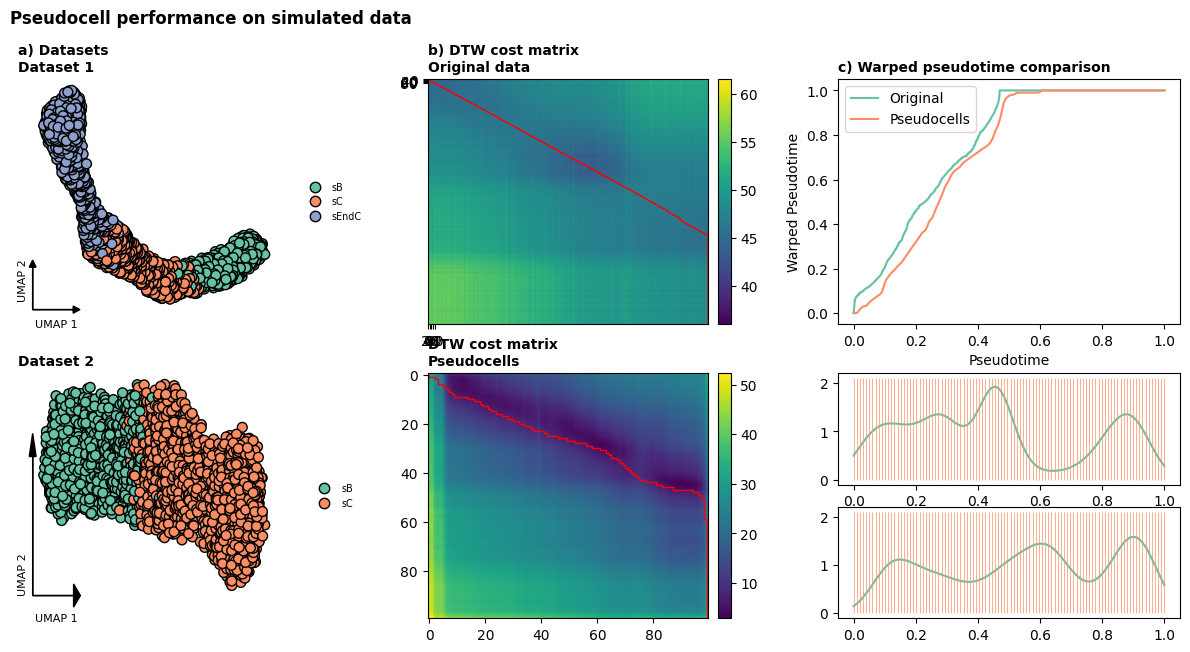

In [ ]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle("Pseudocell performance on simulated data", fontsize=12, fontweight='bold', x=0.12, y=0.98, horizontalalignment='left')
gs_outer = fig.add_gridspec(2, 3, width_ratios = [1,1,1], height_ratios = [1,1])

gsa = gs_outer[0, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axa1, axa2 = gsa.subplots()
gsb = gs_outer[1, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axb1, axb2 = gsb.subplots()
# (axa, axb), (axc, axd), (axe, axf) = gs_outer.subplots()

plot_celltypes(d1, axa1, legendax=axa2)
plot_celltypes(d2, axb1, legendax=axb2)
axa1.set_title("a) Datasets\nDataset 1", fontsize=10, fontweight='bold', loc='left')
axb1.set_title("Dataset 2", fontsize=10, fontweight='bold', loc='left')

axc, axd = gs_outer[:, 1].subgridspec(2, 1).subplots()

# axc = gs_outer[0, 1].subgridspec(1, 1).subplots()
# axd = gs_outer[1, 1].subgridspec(1, 1).subplots()

plot_matrix(d1.obsm['dtw_cost'], (axc,), xticks=[0, 20, 40, 60, 80], yticks=[0, 20, 40, 60, 80], pathx=d1.obs["dtw_path"], pathy=d2.obs["dtw_path"])
plot_matrix(d3.obsm['dtw_cost'], (axd,), xticks=[0, 20, 40, 60, 80], yticks=[0, 20, 40, 60, 80], pathx=d3.obs["dtw_path"], pathy=d4.obs["dtw_path"])

axc.set_title("b) DTW cost matrix\nOriginal data", fontsize=10, fontweight='bold', loc='left')
axd.set_title("DTW cost matrix\nPseudocells", fontsize=10, fontweight='bold', loc='left')

axe = gs_outer[0, 2].subgridspec(1, 1).subplots()
plot_comparisons(d1, ax=axe)
# plot_comparisons(d2, ax=axe[1])
axe.set_title("c) Warped pseudotime comparison", fontsize=10, fontweight='bold', loc='left')

axf, axg = gs_outer[1, 2].subgridspec(2, 1).subplots()

plot_pseudocells(d1, axf)
plot_pseudocells(d2, axg)
